### 1. Import libraries and get data

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

In [34]:
# Load the dataset
df = pd.read_csv("./BTC.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df

,Price
Date,
2017-12-01,10861.5
2017-12-02,10912.7
2017-12-03,11246.2
2017-12-04,11623.9
2017-12-05,11667.1
...,...
2023-06-12,25906.8
2023-06-13,25929.4
2023-06-14,25129.5


In [35]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))
print(df.shape)

(2024, 1)


### 2. Split the data into training, test and validate sets

In [36]:
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1214, 1)
Test shape: (607, 1)
Validate shape: (203, 1)


In [37]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1416, 1)
Test shape: (404, 1)
Validate shape: (204, 1)


In [38]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1214, 1)
Test shape: (404, 1)
Validate shape: (406, 1)


In [39]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [40]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_val, y_val = create_dataset(val_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", x_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", x_test.shape)
print("y_test", y_test.shape)

X_train:  (1113, 100)
y_train:  (1113,)
X_val:  (305, 100)
y_val:  (305,)
X_test:  (303, 100)
y_test (303,)


## 3. Perform XGBoost Model

### 3.1 Build and fit XGBoost Model with train data

In [41]:
xgb_model = XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

xgb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=50, verbose=False)

[00:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

### 3.2 Evaluate on Validate data

In [42]:
def evaludate_xgb_model(x_data, y_data):
    predictions = xgb_model.predict(x_data)
    mse = mean_squared_error(y_data, predictions)
    mae = mean_absolute_error(y_data, predictions)
    mape = mean_absolute_percentage_error(y_data, predictions)
    rmse = mean_squared_error(y_data, predictions, squared=False)
    return predictions, mse, mae, mape, rmse

In [43]:
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaludate_xgb_model(x_val, y_val)

### 3.3 Evaluate on Test data

In [44]:
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaludate_xgb_model(x_test, y_test)

### 3.4 Predict price for the next 30 days

In [45]:
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 30
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = xgb_model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = xgb_model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.6627338]
2 day output [0.6627338]
3 day output [0.6627338]
4 day output [0.6627338]
5 day output [0.6627338]
6 day output [0.6627338]
7 day output [0.6627338]
8 day output [0.6627338]
9 day output [0.6627338]
10 day output [0.6627338]
11 day output [0.6627338]
12 day output [0.6627338]
13 day output [0.6627338]
14 day output [0.6627338]
15 day output [0.6627338]
16 day output [0.6627338]
17 day output [0.6627338]
18 day output [0.6627338]
19 day output [0.6627338]
20 day output [0.6627338]
21 day output [0.6627338]
22 day output [0.6627338]
23 day output [0.6627338]
24 day output [0.6627338]
25 day output [0.6627338]
26 day output [0.6627338]
27 day output [0.6627338]
28 day output [0.6627338]
29 day output [0.6627338]
Output of predicted next days:  [0.642625093460083, 0.662733793258667, 0.662733793258667, 0.662733793258667, 0.662733793258667, 0.662733793258667, 0.662733793258667, 0.662733793258667, 0.662733793258667, 0.662733793258667, 0.662733793258667, 0.66273379325

In [46]:
y_pred_test = y_pred_test.reshape(-1,1)
y_pred_val = y_pred_val.reshape(-1,1)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

print("Test data prediction:", y_pred_test.shape)
print("Val data prediction:", y_pred_val.shape)

Test data prediction: (303, 1)
Val data prediction: (305, 1)


In [47]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

acc = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(acc)

               MSE       MAE      MAPE      RMSE
Validate  0.109463  0.324935  1.201518  0.330853
Test      0.009475  0.078955  0.124551  0.097341


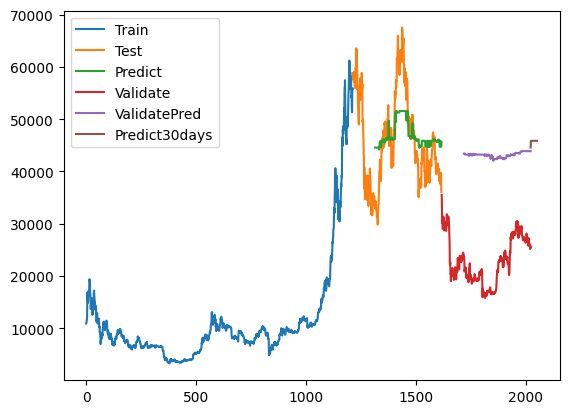

In [48]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_test)

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)

plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()